In [38]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.plotting import register_matplotlib_converters
import pandas.util.testing as ptest
import statsmodels.api as sm
from   statsmodels.tsa.api import DynamicVAR, VAR
from   statsmodels.tsa.base.datetools import dates_from_str

%matplotlib inline
register_matplotlib_converters()

# VAR(p) Process

In [6]:
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates['year'] + 'Q' + dates['quarter']
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp', 'realcons', 'realinv']]
mdata.index = pd.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()
data.head()

,realgdp,realcons,realinv
1959-06-30,0.024942,0.015286,0.080213
1959-09-30,-0.001193,0.010386,-0.072131
1959-12-31,0.003495,0.001084,0.034425
1960-03-31,0.022190,0.009534,0.102664
1960-06-30,-0.004685,0.012572,-0.106694


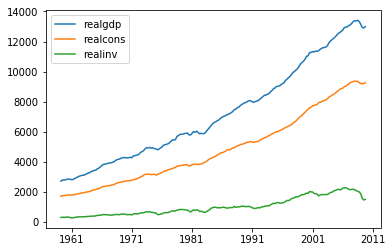

In [10]:
for f in list(mdata):
    plt.plot(mdata.index, mdata[f], label=f)
    plt.legend();

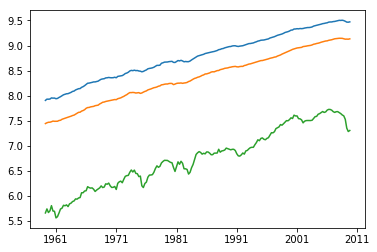

In [8]:
for f in list(mdata):
    plt.plot(mdata.index, np.log(mdata[f]))

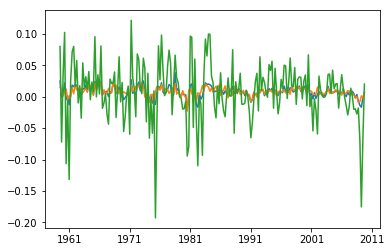

In [11]:
for f in list(data):
    plt.plot(data.index, data[f])

In [12]:
model = VAR(data)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [13]:
results = model.fit(2) # VAR(2)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Jul, 2019
Time:                     07:32:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.5830
Nobs:                     200.000    HQIC:                  -27.7892
Log likelihood:           1962.57    FPE:                7.42129e-13
AIC:                     -27.9293    Det(Omega_mle):     6.69358e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001527         0.001119            1.365           0.172
L1.realgdp         -0.279435         0.169663           -1.647           0.100
L1.realcons         0.675016         0.131285            5.142    

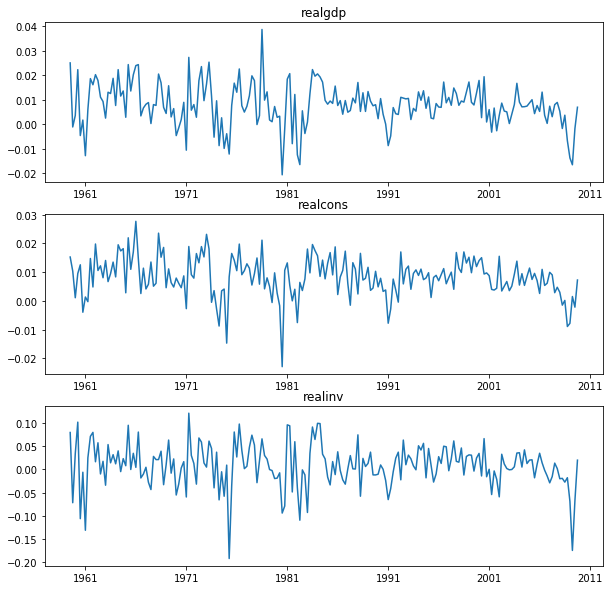

In [14]:
results.plot(); # same as last plot above

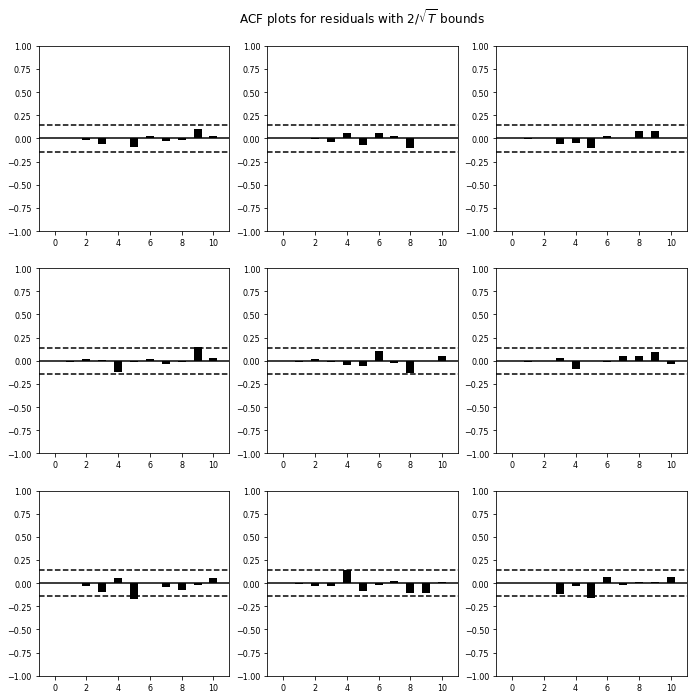

In [21]:
results.plot_acorr(); 

In [16]:
# Find optimal lag order
model.select_order(15)
results = model.fit(maxlags=15, ic='aic')

In [17]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 19, Jul, 2019
Time:                     07:38:51
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -27.4257
Nobs:                     199.000    HQIC:                  -27.7212
Log likelihood:           1961.15    FPE:                7.47593e-13
AIC:                     -27.9222    Det(Omega_mle):     6.45336e-13
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.001281         0.001295            0.989           0.322
L1.realgdp         -0.286148         0.171582           -1.668           0.095
L1.realcons         0.673869         0.132245            5.096    

In [18]:
lag_order = results.k_ar
lag_order

3

In [19]:
results.forecast(data.values[-lag_order:], 5)

array([[ 0.00616044,  0.00500006,  0.00916198],
       [ 0.00427559,  0.00344836, -0.00238478],
       [ 0.00416634,  0.0070728 , -0.01193629],
       [ 0.00557873,  0.00642784,  0.00147152],
       [ 0.00626431,  0.00666715,  0.00379567]])

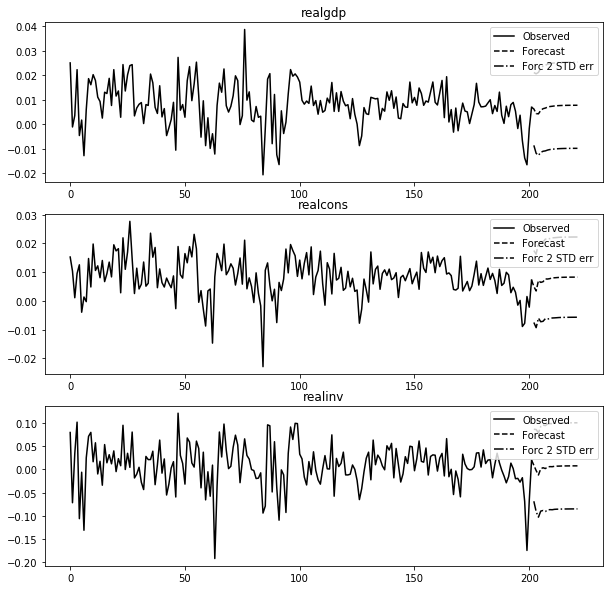

In [22]:
results.plot_forecast(20);

# Impulse Response Analysis

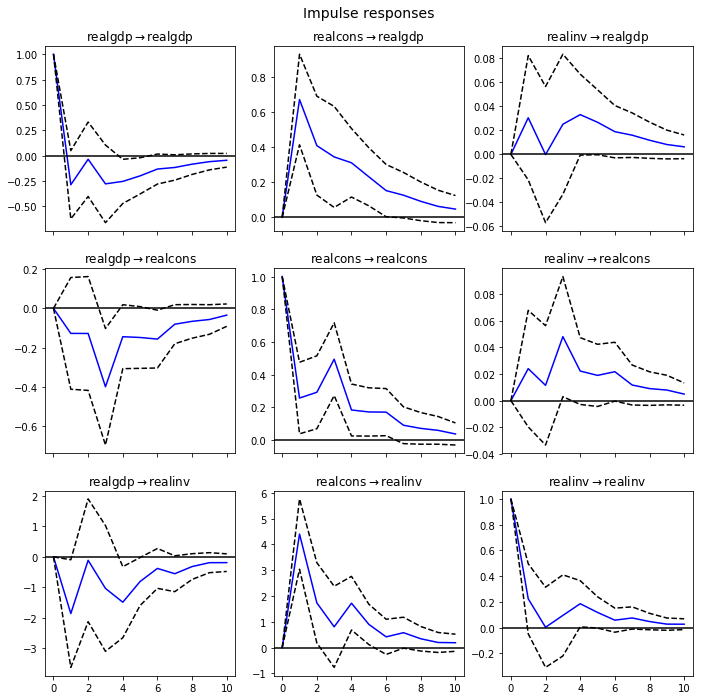

In [24]:
irf = results.irf(10)
irf.plot(orth=False);

In [26]:
#irf.plot(orth=True);

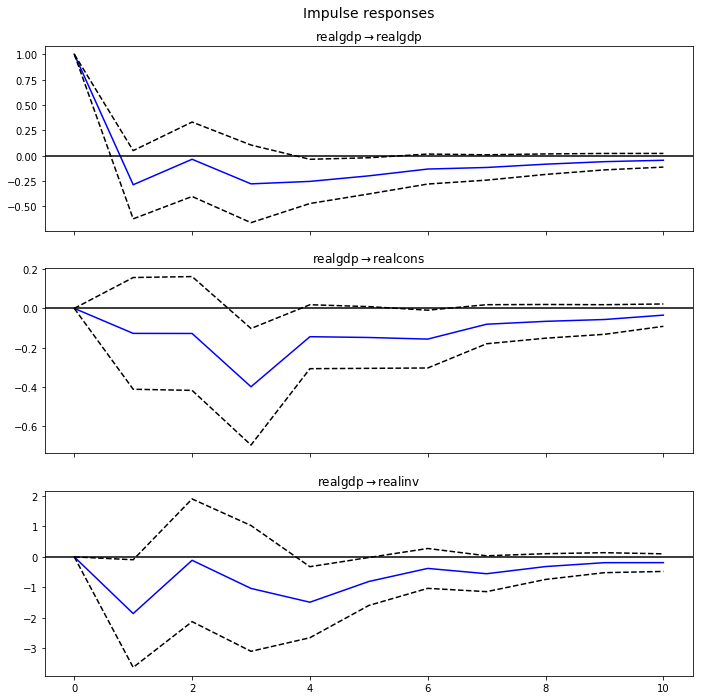

In [28]:
# Plot only specific values
irf.plot(impulse='realgdp');

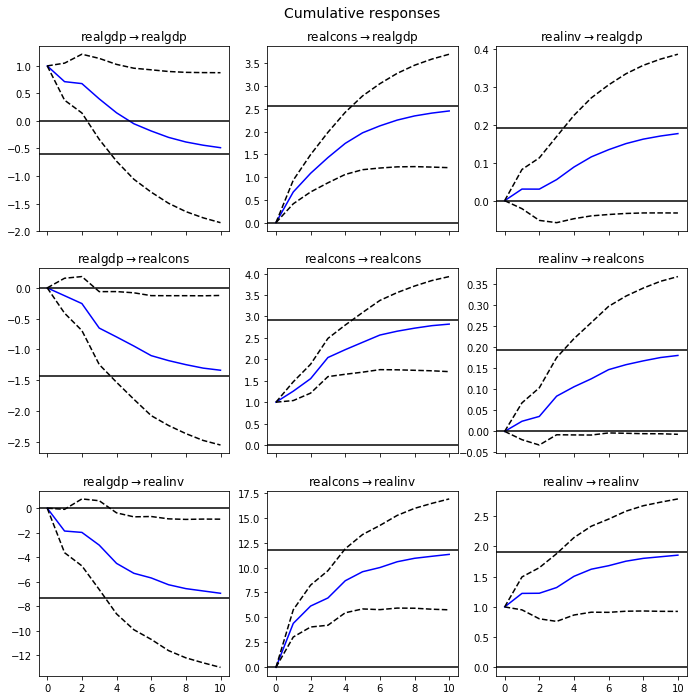

In [30]:
irf.plot_cum_effects(orth=False);

# Forecast Error Variance Decomposition (FEVD)

In [31]:
fevd = results.fevd(5) # 5 = no. steps ahead
fevd.summary()

FEVD for realgdp
      realgdp  realcons   realinv
0    1.000000  0.000000  0.000000
1    0.864889  0.129253  0.005858
2    0.816725  0.177898  0.005378
3    0.793647  0.197590  0.008763
4    0.777279  0.208127  0.014594

FEVD for realcons
      realgdp  realcons   realinv
0    0.359877  0.640123  0.000000
1    0.358767  0.635420  0.005813
2    0.348044  0.645138  0.006817
3    0.319913  0.653609  0.026478
4    0.317407  0.652180  0.030414

FEVD for realinv
      realgdp  realcons   realinv
0    0.577021  0.152783  0.270196
1    0.488158  0.293622  0.218220
2    0.478727  0.314398  0.206874
3    0.477182  0.315564  0.207254
4    0.466741  0.324135  0.209124




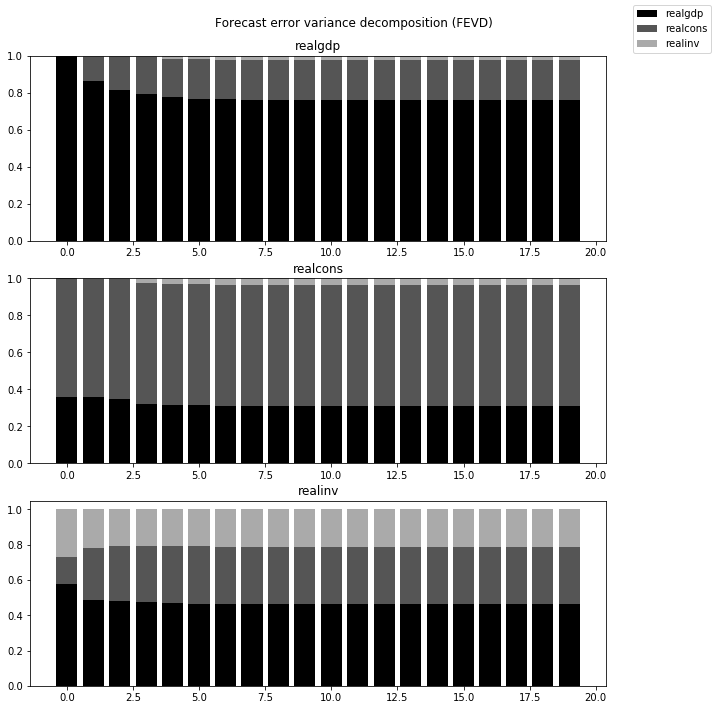

In [32]:
results.fevd(20).plot();

In [33]:
# Granger Causality
results.test_causality('realgdp', ['realinv', 'realcons'], kind='f')

Normality/"Whiteness" of residuals
# Dynamic VAR

In [36]:
np.random.seed(38)
ptest.N = 500
data = ptest.makeTimeDataFrame().cumsum(0)
data.head()

,A,B,C,D
2000-01-03,1.008706,-0.135238,-0.130216,2.129763
2000-01-04,0.685582,2.171171,0.555471,2.006505
2000-01-05,0.813329,3.926332,0.923695,2.717929
2000-01-06,1.093102,3.475534,-0.322520,6.195750
2000-01-07,2.381833,4.729218,0.442966,6.805043


In [40]:
var = DynamicVAR(data, lag_order=2, window_type='expanding')

In [41]:
var.coefs

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/dynamic.py:246: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  panel = pd.Panel.fromDict(data)
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/dynamic.py:249: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  return panel.swapaxes('items', 'minor')


<class 'pandas.core.panel.Panel'>
Dimensions: 9 (items) x 489 (major_axis) x 4 (minor_axis)
Items axis: L1.A to intercept
Major_axis axis: 2000-01-18 00:00:00 to 2001-11-30 00:00:00
Minor_axis axis: A to D

In [42]:
var.coefs.minor_xs('A').info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 489 entries, 2000-01-18 to 2001-11-30
Freq: B
Data columns (total 9 columns):
L1.A         489 non-null float64
L1.B         489 non-null float64
L1.C         489 non-null float64
L1.D         489 non-null float64
L2.A         489 non-null float64
L2.B         489 non-null float64
L2.C         489 non-null float64
L2.D         489 non-null float64
intercept    489 non-null float64
dtypes: float64(9)
memory usage: 58.2 KB


In [43]:
var.coefs.major_xs(dt.datetime(2001, 11, 30)).T

,A,B,C,D
L1.A,1.006638,-0.005855,0.007040,-0.065933
L1.B,-0.047037,0.977618,0.059625,0.045593
L1.C,-0.031372,-0.021308,0.894818,-0.081315
L1.D,-0.027697,-0.019501,0.031304,1.015139
L2.A,-0.013976,0.010013,-0.010140,0.057392
L2.B,0.022701,-0.024882,-0.095634,-0.070692
L2.C,0.029108,0.041557,0.060713,0.072015
L2.D,0.021916,0.004896,-0.052289,-0.038769
intercept,0.459132,0.318652,0.644841,0.899861


In [44]:
var.forecast(2)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/dynamic.py:264: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  coef_panel = self.coefs.copy()
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/dynamic.py:267: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  coef_values = coef_panel.swapaxes('items', 'major').values


,A,B,C,D
2000-01-20,-61.930821,17.359344,-50.505050,-29.005267
2000-01-21,-41.596408,15.790836,-36.051924,-15.263788
2000-01-24,-46.705464,19.231220,-52.347967,-21.629460
2000-01-25,-3.344323,9.677752,0.847696,11.261815
2000-01-26,0.893429,7.846960,3.135093,10.154964
2000-01-27,15.837567,0.005920,13.665635,13.784933
2000-01-28,11.989330,5.473367,10.129732,11.119395
2000-01-31,14.913630,3.448998,14.422503,13.654614
2000-02-01,15.633191,5.299309,16.843334,11.917406
2000-02-02,16.754265,5.980166,21.020988,11.954439


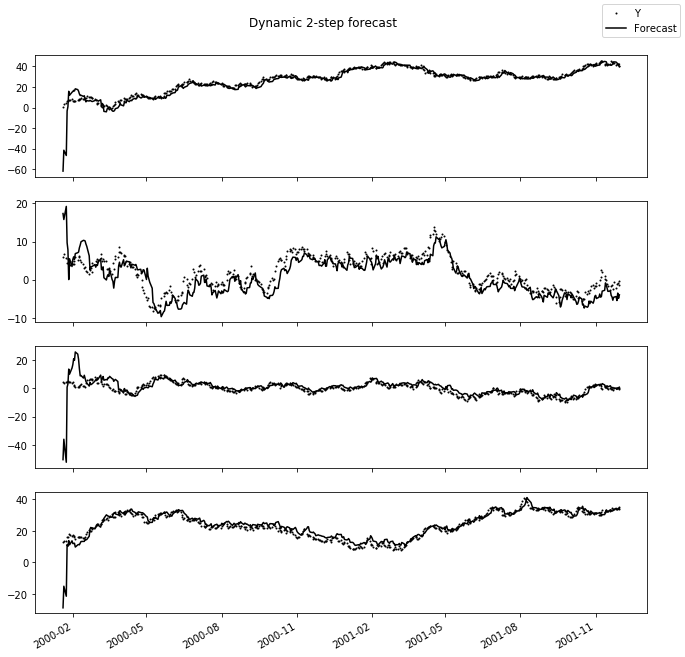

In [46]:
var.plot_forecast(2);

# Vector Error Correction Models (VECM)